*How many qualitative and quantitative variables are there? What are appropiate visuals for quantitative vs qualitative data? What are appropiate measures for correlations when dealing with qualitative and quantitative variables?

What is the correlation between the variables and the price? Why do you think some variables are more correlated than others?

How are the variables themselves correlated to each other? Can you find groups of variables that are correlated together?*

In [23]:
#Import the clean data file
import pandas as pd
import numpy as np
import seaborn as sns

file_path = "cleaned_properties.csv"
with open(file_path, 'r', encoding='utf-8') as f:
    first_line = f.readline()
    sep = ';' if ';' in first_line else ','
df = pd.read_csv(file_path, sep=sep, low_memory=False)

In [24]:
# Capping and log transformations

df_before = df.copy() #Keeping a copy of data before capping
cap_vars = ['price', 'surface_land_sqm', 'total_area_sqm','garden_sqm', 'terrace_sqm', 'nbr_bedrooms', 'nbr_frontages']
lower_cap = 0.01
upper_cap = 0.99
for var in cap_vars:
    lower = df[var].quantile(lower_cap)
    upper = df[var].quantile(upper_cap)
    df[var] = np.where(df[var] < lower, lower,
                       np.where(df[var] > upper, upper, df[var]))

# Initiating the log transfiormations
log_vars = ['price', 'surface_land_sqm', 'total_area_sqm','garden_sqm', 'terrace_sqm']
for var in log_vars:
    df[f'{var}_log'] = np.log1p(df[var])
df[[f'{v}_log' for v in log_vars]].skew()


price_log               0.632884
surface_land_sqm_log   -1.389096
total_area_sqm_log     -2.104580
garden_sqm_log          2.013560
terrace_sqm_log         0.686216
dtype: float64

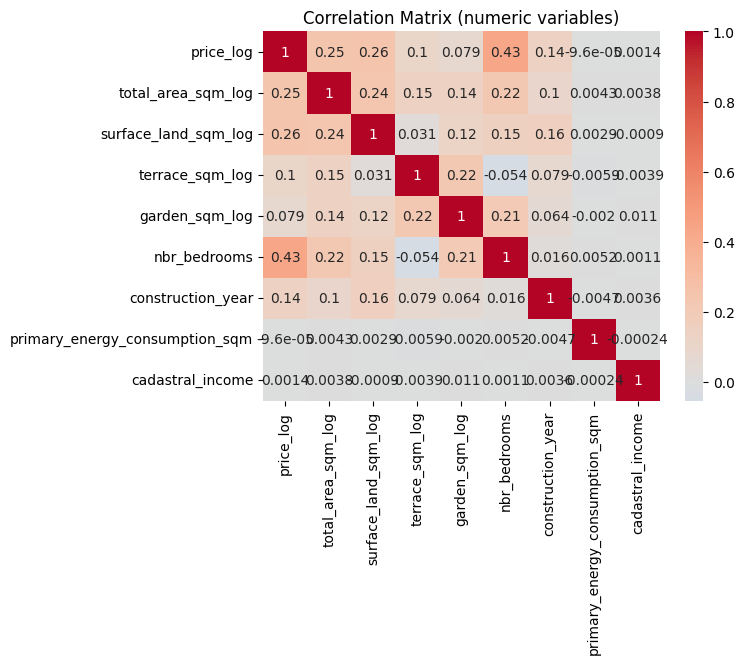

In [25]:
# Corr between price and continuous (numeric) variables (Correlation Matrix) - Pearson's corr
import matplotlib.pyplot as plt

#Numeric vars
num_cols = ['price_log', 'total_area_sqm_log', 'surface_land_sqm_log', 'terrace_sqm_log','garden_sqm_log', 'nbr_bedrooms', 'construction_year', 'primary_energy_consumption_sqm','cadastral_income']

corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix (numeric variables)")
plt.show()

In [26]:
# which regions/ provinces have the highest median prices

df.groupby('region')['price'].median().sort_values(ascending=False)

region
Brussels-Capital    3800000.0
Flanders            3511500.0
Wallonia            2700000.0
Name: price, dtype: float64

In [28]:
# Holistic .corr Analysis with Numeric/log-tranformed variables - Pearson's 
'''
Interpretation
Pearson r:
0.0–0.3 -> weak correlation
0.3–0.6 -> moderate correlation
0.6–0.9 -> strong correlation
0.9+ -> very strong correlation
p-value:
Small p (<0.05) -> correlation is statistically significant
Large p (≥0.05) -> not significant; could be noise
'''

from scipy.stats import pearsonr

num_cols = ['price_log', 'total_area_sqm_log', 'surface_land_sqm_log', 'terrace_sqm_log','garden_sqm_log', 'nbr_bedrooms', 'construction_year', 'primary_energy_consumption_sqm', 'cadastral_income']

rows = []

for i, col1 in enumerate(num_cols):
    for j, col2 in enumerate(num_cols):
        if i <= j:  # avoid repeating pairs
            r, p = pearsonr(df[col1].fillna(0), df[col2].fillna(0))  # fill NA safely
            rows.append({'Variable 1': col1,'Variable 2': col2,'Pearson r': r,'p-value': p})

# Convert to DataFrame
corr_table = pd.DataFrame(rows)

# Sort by correlation with price
price_corr = corr_table[corr_table['Variable 1']=='price_log'].sort_values(by='Pearson r', ascending=False)
price_corr

,Variable 1,Variable 2,Pearson r,p-value
0,price_log,price_log,1.000000,0.000000e+00
5,price_log,nbr_bedrooms,0.434124,0.000000e+00
1,price_log,total_area_sqm_log,0.247447,0.000000e+00
2,price_log,surface_land_sqm_log,0.231693,0.000000e+00
6,price_log,construction_year,0.139864,0.000000e+00
3,price_log,terrace_sqm_log,0.103844,4.888415e-180
4,price_log,garden_sqm_log,0.078613,8.508240e-104
7,price_log,primary_energy_consumption_sqm,-0.000646,8.590339e-01
8,price_log,cadastral_income,-0.000768,8.327911e-01


In [29]:
# Inter-numeric-variables correaltions - detect possible multicollinearity in regressions later on

corr_matrix = df[num_cols].corr(method='pearson') 
corr_matrix
corr_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().reset_index())
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Pearson r']
corr_pairs = corr_pairs.sort_values(by='Pearson r', ascending=False)
corr_pairs



,Variable 1,Variable 2,Pearson r
4,price_log,nbr_bedrooms,0.434124
1,price_log,surface_land_sqm_log,0.257445
0,price_log,total_area_sqm_log,0.247447
8,total_area_sqm_log,surface_land_sqm_log,0.241412
11,total_area_sqm_log,nbr_bedrooms,0.223191
21,terrace_sqm_log,garden_sqm_log,0.222789
26,garden_sqm_log,nbr_bedrooms,0.208865
18,surface_land_sqm_log,construction_year,0.155846
17,surface_land_sqm_log,nbr_bedrooms,0.151743
9,total_area_sqm_log,terrace_sqm_log,0.146911


In [33]:
#Checking the categorical variables for unique values
#fl_swimming_pool causing error in ANOVA due to single unique value

for var in cat_vars:
    print(var, df[var].nunique())

property_type 2
subproperty_type 23
region 3
province 11
epc 9
heating_type 7
state_building 6
fl_swimming_pool 2
fl_open_fire 2
fl_terrace 2
fl_garden 2
fl_double_glazing 2


In [ ]:
# Categorical vs price analysis - ANOVA
# F-statistic and p-value indicate whether the categorical variables have significant effects on price
# F- statistic: Measures how large the price differences are between categories relative to within-category variation (higher F -> stronger signal -> the variable kilely affects price).
# p-value: probability these differences happened by chance


import statsmodels.api as sm
from statsmodels.formula.api import ols

# Example for variable property_type
model = ols('price_log ~ C(property_type)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Iterating over all categorical variables
cat_vars = ['property_type', 'subproperty_type', 'region', 'province', 'epc', 'heating_type', 'state_building','fl_swimming_pool',
    'fl_open_fire', 'fl_terrace', 'fl_garden', 'fl_double_glazing']
#'fl_swimming_pool'
anova_results = []

for var in cat_vars:
    model = ols(f'price_log ~ C({var})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    F = anova_table['F'].iloc[0]
    p = anova_table['PR(>F)'].iloc[0]
    anova_results.append({'Variable': var, 'F-statistic': F, 'p-value': p})

anova_df = pd.DataFrame(anova_results)
anova_df = anova_df.sort_values(by='F-statistic', ascending=False)
display(anova_df)

#Interpretation of Results: 
# - Prices differ massively across Belgium’s regions - top predictor
# - Swimming pool in place - top predictor
# - Houses vs apartments have big price differences - storng predictor
# - Provincial differences in prices are large - strong predictor
# - State of building (good/renovated/to renovate) heavily impacts price - strong predictor
# - Subproperty type - important predictor
# - [NOT stat significant] Whether a terrace exists significantly impacts price - strong predictor
# - Energy efficiency (epc) has medium-strong influence - medium-strong predictor
# - [NOT stat significant] Garden - medium predictor
# - [NOT stat significant] Heating type - weak-medium predictor
# - [NOT stat significant] Double glazing - weak predictor
# - [NOT stat significant] Open fire - very weak predictor


                        sum_sq       df            F  PR(>F)
C(property_type)    552.594406      1.0  1794.127538     0.0
Residual          23254.747498  75502.0          NaN     NaN


,Variable,F-statistic,p-value
2,region,3222.849889,0.000000e+00
7,fl_swimming_pool,2350.980411,0.000000e+00
0,property_type,1794.127538,0.000000e+00
3,province,964.705883,0.000000e+00
6,state_building,660.446362,0.000000e+00
1,subproperty_type,637.214493,0.000000e+00
9,fl_terrace,410.660627,4.604019e-91
4,epc,367.156630,0.000000e+00
10,fl_garden,314.048517,3.977734e-70
5,heating_type,87.613275,1.140725e-109


In [ ]:
# Inter-correlations: Categorical and categorical - Chi square test
